In [1]:
import cv2
import mediapipe as mp
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt
import json
import random
import time
import pandas as pd
%matplotlib inline

In [112]:
def read_data(_path):
    _data = pd.read_csv(_path)
    _data.drop(['Unnamed: 0'], axis="columns", inplace=True)
    return _data

In [113]:
markers_path = os.path.join('dataset', 'markers')
labels = os.listdir(markers_path)
y_train_data = []
for i, label in enumerate(labels):
    csv_list = os.listdir(os.path.join(markers_path, label))
    for csv in csv_list:
        y_train_data.append(i)
y_train_data = np.array(tf.one_hot(np.array(y_train_data), len(labels)))
print(f'y_train_data = {y_train_data.shape}')
y_train_data_num = np.sum(y_train_data, 0)
for i, n in enumerate(y_train_data_num):
    print(f'{i}. {labels[i]}: {int(n)}')

y_train_data = (1500, 3)
0. paper: 500
1. scissors: 500
2. Stone: 500


In [20]:
markers_path = os.path.join('dataset', 'markers')
ont_data_path = os.path.join(markers_path, 'yeah', '0.csv')
data = read_data(ont_data_path)
data.head(5)

,x,y,z
0,0.403830,0.852787,3.602019e-07
1,0.403002,0.791748,-8.087947e-03
2,0.417622,0.727613,-2.661067e-02
3,0.444915,0.693341,-4.581104e-02
4,0.459773,0.681325,-6.267484e-02


In [114]:
labels = os.listdir(markers_path)
print('labels:')
for i, label in enumerate(labels):
    print(f'{i}. {label}')

labels:
0. paper
1. scissors
2. Stone


In [127]:
y_train_data = []
x_train_data = []
for i, label in enumerate(labels):
    csv_list = os.listdir(os.path.join(markers_path, label))
    for csv in csv_list:
        csv_path = os.path.join(markers_path, label, csv)
        data = read_data(csv_path)
        x_train_data.append(data.copy())
        y_train_data.append(i)
        # data.x = 0.5 - (data.x - 0.5)
        # data.y = 0.5 - (data.y - 0.5)
        # x_train_data.append(data)
        # y_train_data.append(i)
x_train_data = np.array(x_train_data)
y_train_data = np.array(tf.one_hot(np.array(y_train_data), len(labels)))
print(f'x_train_data = {x_train_data.shape}')
print(f'y_train_data = {y_train_data.shape}')

x_train_data = (1500, 21, 3)
y_train_data = (1500, 3)


In [128]:
y_train_data_num = np.sum(y_train_data, 0)
for i, n in enumerate(y_train_data_num):
    print(f'{i}. {labels[i]}: {int(n)}')

0. paper: 500
1. scissors: 500
2. Stone: 500


In [129]:
print('before normalization:')
data_limits = np.min(np.min(x_train_data, 0), 0), np.max(np.max(x_train_data, 0), 0)
print(f'data.x = {data_limits[0][0]:5.2f} ~ {data_limits[1][0]:4.2f}')
print(f'data.y = {data_limits[0][1]:5.2f} ~ {data_limits[1][1]:4.2f}')
print(f'data.z = {data_limits[0][2]:5.2f} ~ {data_limits[1][2]:4.2f}')

before normalization:
data.x =  0.10 ~ 0.87
data.y =  0.21 ~ 1.04
data.z = -0.18 ~ 0.04


In [130]:
norm_min, norm_max = -0.2, 0.1
x_train_data[:, :, 2] = (x_train_data[:, :, 2] - norm_min) / (norm_max - norm_min)
print('after normalization:')
data_limits = np.min(np.min(x_train_data, 0), 0), np.max(np.max(x_train_data, 0), 0)
print(f'data.x = {data_limits[0][0]:5.2f} ~ {data_limits[1][0]:4.2f}')
print(f'data.y = {data_limits[0][1]:5.2f} ~ {data_limits[1][1]:4.2f}')
print(f'data.z = {data_limits[0][2]:5.2f} ~ {data_limits[1][2]:4.2f}')

after normalization:
data.x =  0.10 ~ 0.87
data.y =  0.21 ~ 1.04
data.z =  0.07 ~ 0.81


In [131]:
random_seed = 0
np.random.seed(random_seed)
randomList = np.arange(x_train_data.shape[0])
np.random.shuffle(randomList)
x_train_data, y_train_data = x_train_data[randomList], y_train_data[randomList]
print(f'randomList = {randomList}')

randomList = [ 471    9 1499 ... 1216  559  684]


In [132]:
train_num = int(x_train_data.shape[0] * 0.8)
val_num = int(x_train_data.shape[0] * 0.2)
# test_num = int(x_train_data.shape[0] * 0.0)
x_train = np.array(x_train_data[:train_num])
y_train = np.array(y_train_data[:train_num])
x_val = np.array(x_train_data[train_num:train_num+val_num])
y_val = np.array(y_train_data[train_num:train_num+val_num])
# x_test = np.array(x_train_data[-test_num:])
# y_test = np.array(y_train_data[-test_num:])
print(f'x_train = {x_train.shape}, y_train = {y_train.shape}')
print(f'x_val = {x_val.shape}, y_val = {y_val.shape}')
# print(f'x_test = {x_test.shape}, y_test = {y_test.shape}')

x_train = (1200, 21, 3), y_train = (1200, 3)
x_val = (300, 21, 3), y_val = (300, 3)


In [207]:
x_train = x_train[:, :, :, np.newaxis]
x_val = x_val[:, :, :, np.newaxis]
print(f'x_train = {x_train.shape}, y_train = {y_train.shape}')
print(f'x_val = {x_val.shape}, y_val = {y_val.shape}')

x_train = (1200, 21, 3, 1), y_train = (1200, 3)
x_val = (300, 21, 3, 1), y_val = (300, 3)


layers_num = 6, params_num = 24931

Model: "Conv2D_Double"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               (None, 20, 2, 32)         160       
_________________________________________________________________
hidden_1 (Conv2D)            (None, 19, 1, 32)         4128      
_________________________________________________________________
flatten_69 (Flatten)         (None, 608)               0         
_________________________________________________________________
hidden_2 (Dense)             (None, 32)                19488     
_________________________________________________________________
hidden_3 (Dense)             (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 3)                 99        
Total params: 24,931
Trainable params: 24,931
Non-trainable params: 0
_____________

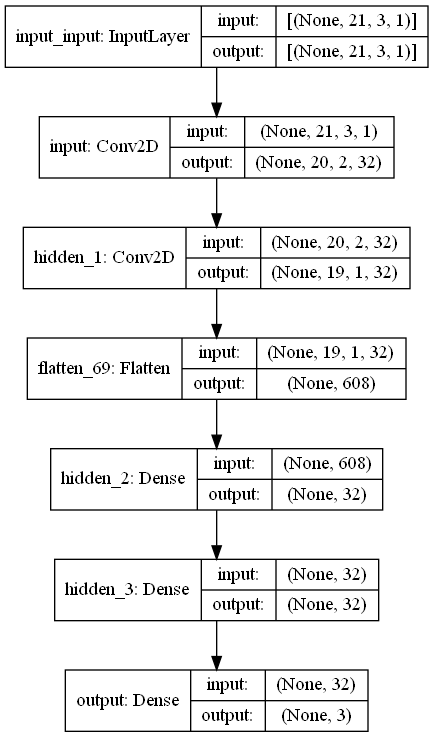

In [219]:
# model = keras.Sequential([
#     layers.Conv1D(64, kernel_size=2, strides=1, padding='valid', activation='relu', input_shape=(21, 3,), name='input'),
#     # layers.MaxPooling1D(pool_size=2, padding='valid'),
#     layers.Conv1D(32, kernel_size=2, strides=1, padding='valid', activation='relu', name='hidden_1'),
#     layers.MaxPooling1D(pool_size=2, padding='valid', name='hidden_2'),
#     # layers.BatchNormalization(),
#     layers.Flatten(name='hidden_3'),
#     layers.Dense(32, activation='relu', name='hidden_4'),
#     # layers.Dropout(0.2),
#     # layers.Dense(32, activation='relu', name='hidden_5'),
#     # layers.Dropout(0.2),
#     layers.Dense(len(labels), activation='softmax', name='output')
# ], name='Conv1D_Double')
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=2, strides=1, padding='valid', activation='relu', input_shape=(21, 3, 1,), name='input'),
    layers.Conv2D(32, kernel_size=2, strides=1, padding='valid', activation='relu', name='hidden_1'),
    layers.Flatten(),
    layers.Dense(32, activation='relu', name='hidden_2'),
    layers.Dense(32, activation='relu', name='hidden_3'),
    layers.Dense(len(labels), activation='softmax', name='output')
], name='Conv2D_Double')
# model = keras.Sequential([
#     layers.Flatten(input_shape=(21, 3,), name='input'),
#     layers.Dense(64, activation='relu', name='hidden_1'),
#     layers.Dense(64, activation='relu', name='hidden_2'),
#     layers.Dense(32, activation='relu', name='hidden_3'),
#     layers.Dense(32, activation='relu', name='hidden_4'),
#     layers.Dense(len(labels), activation='softmax', name='output')
# ], name='Flatten_Dense')
params_num = model.count_params()
layers_num = len(model.layers)
print(f'layers_num = {layers_num}, params_num = {params_num}\n')
model.summary()
plot_model(model, show_shapes=True)

In [214]:
''' trainParam '''
save_models = 'new_output_models'
model_tag = model.name
optimizer = "adam"
loss = "mse"
batch_size = 512
epochs = 10000
time_tag = time.strftime("%Y_%m_%d-%H_%M_%S", time.localtime())
model_dir = f'{time_tag}-{model_tag}-params_{params_num}-batch_{batch_size}-optimizer_{optimizer}-loss_{loss}'
print(os.path.join(save_models, model_dir))
callbacks = list()
model.compile(optimizer=optimizer, loss=loss, metrics=['mae', 'acc'])
''' EarlyStopping '''
callbacks.append(
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="auto")
)
''' ModelCheckpoint '''
model_name = 'epoch_{epoch:03d}-val_loss_{val_loss:.3f}.hdf5'
all_filepath = os.path.join(save_models, model_dir, 'all_models', model_name)
callbacks.append(
    keras.callbacks.ModelCheckpoint(all_filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
)
best_filepath = os.path.join(save_models, model_dir, 'model.hdf5')
callbacks.append(
    keras.callbacks.ModelCheckpoint(best_filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
)
''' TensorBoard '''
log_dir = os.path.join(save_models, 'logs', model_dir)
callbacks.append(
    keras.callbacks.TensorBoard(log_dir=log_dir)
)

new_output_models\2022_05_01-20_42_56-Conv2D_Double-params_24931-batch_512-optimizer_adam-loss_mse


In [215]:
trainHistory = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/10000
3/3 [==============================] - 1s 195ms/step - loss: 0.2226 - mae: 0.4445 - acc: 0.3158 - val_loss: 0.2207 - val_mae: 0.4428 - val_acc: 0.4133
Epoch 2/10000
3/3 [==============================] - 0s 36ms/step - loss: 0.2208 - mae: 0.4430 - acc: 0.3900 - val_loss: 0.2201 - val_mae: 0.4421 - val_acc: 0.3267
Epoch 3/10000
3/3 [==============================] - 0s 70ms/step - loss: 0.2199 - mae: 0.4419 - acc: 0.3383 - val_loss: 0.2189 - val_mae: 0.4409 - val_acc: 0.3600
Epoch 4/10000
3/3 [==============================] - 0s 55ms/step - loss: 0.2185 - mae: 0.4406 - acc: 0.4367 - val_loss: 0.2170 - val_mae: 0.4390 - val_acc: 0.4667
Epoch 5/10000
3/3 [==============================] - 0s 55ms/step - loss: 0.2170 - mae: 0.4388 - acc: 0.4450 - val_loss: 0.2154 - val_mae: 0.4371 - val_acc: 0.5300
Epoch 6/10000
3/3 [==============================] - 0s 69ms/step - loss: 0.2153 - mae: 0.4371 - acc: 0.5367 - val_loss: 0.2138 - val_mae: 0.4356 - val_acc: 0.6433
Epoch 7/10000
3

In [110]:
best_model_epoch = trainHistory.history['loss'].index(min(trainHistory.history['loss'])) + 1
with open(os.path.join(save_models, model_dir, 'READMD.md'), 'w', encoding='utf-8') as file:
    file.write('訓練結果：\n')
    file.write(f'\t{trainHistory.history.keys()}\n')
    file.write(f'\tbest_model_epoch = {best_model_epoch}\n')

**繪製Loss線**

2022_05_01-20_42_56-Conv2D_Double-params_24931-batch_512-optimizer_adam-loss_mse-history_loss.jpg


FileNotFoundError: [Errno 2] No such file or directory: 'new_output_models\\2022_05_01-20_42_56-Conv2D_Double-params_24931-batch_512-optimizer_adam-loss_mse\\2022_05_01-20_42_56-Conv2D_Double-params_24931-batch_512-optimizer_adam-loss_mse-history_loss.jpg'

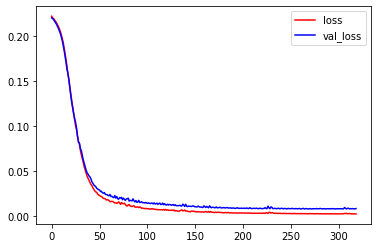

In [218]:
def draw_history(key):
    filename = f'{model_dir}-history_{key}.jpg'
    path = os.path.join(save_models, model_dir, filename)
    plt.plot(trainHistory.history[key], color='r', label=key)
    plt.plot(trainHistory.history[f'val_{key}'], color='b', label=f'val_{key}')
    plt.legend()
    print(filename)
    plt.savefig(path)
    plt.show()

draw_history('loss')
# draw_history('acc')

### 匯出模型

# 測試模型

In [30]:
len(x_test), len(y_test)

(902, 902)

In [29]:
evaluate = model.evaluate(x_test, y_test)
evaluate

29/29 [==============================] - 0s 4ms/step - loss: 0.0222 - mae: 0.0412 - acc: 0.8503


[0.022187896072864532, 0.041169457137584686, 0.8503326177597046]

In [25]:
start_time = time.time()
predicted = model.predict(x_test)
print(f'runtime = {(time.time() - start_time) * 1000:.2f}ms')

runtime = 96.72ms


In [27]:
for i in range(10):
    start_time = time.time()
    predicted = model.predict(x_test)
    print(f'runtime = {(time.time() - start_time) * 1000:.2f}ms')

runtime = 84.81ms
runtime = 77.38ms
runtime = 77.38ms
runtime = 72.33ms
runtime = 81.34ms
runtime = 73.41ms
runtime = 58.03ms
runtime = 70.43ms
runtime = 67.46ms
runtime = 59.27ms


In [28]:
max_loss = list()
sum = 0
for i, y in enumerate(y_test):
    ans = abs(y - predicted[i][0])
    if ans > 0.0075:
        max_loss.append((i, ans))
    sum += ans
    # print(f'{ans:.2f}, {predicted[i][0]:.2f}, {y}')
print(f'acc = {1 - sum / (len(y_test) * 100):.5f}%')
print(f'len(Y_test) = {len(y_test)}')
print(f'len(max_loss) = {len(max_loss)}')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [91]:
with open(os.path.join(save_models, model_dir, 'READMD.md'), 'a', encoding='utf-8') as file:
    file.write('測試結果：\n')
    file.write(f'\tacc = {1 - sum / (len(Y_test) * 100):.5f}%\n')

212, loss = 0.03202640637755394


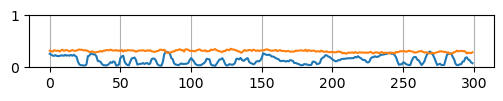

4, loss = 0.012913763523101807


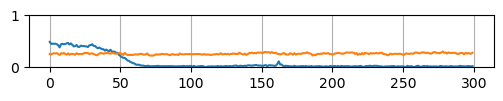

192, loss = 0.009537458419799805


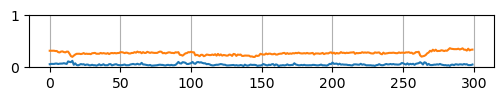

68, loss = 0.018325231969356537


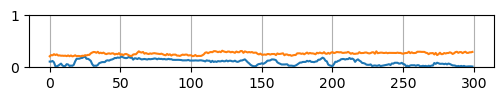

78, loss = 0.008963406085968018


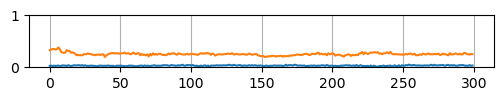

In [92]:
times = 5

def drawTrain(i, num):
    plt.figure(dpi=100)
    plt.subplot(10 + i + 100 * times)
    plt.plot(X_tests[num,:,0], label='mar')
    plt.plot(X_tests[num,:,1], label='entropy')
    print(f'{num}, loss = {max_loss[num][1]}')
    plt.ylim(0, 1)
    # plt.legend()
    plt.grid(True)
    plt.show()

def getRnd():
    return random.randint(0, len(max_loss) - 1)

for i in range(times):
    drawTrain(i + 1, getRnd())